# CONTENT BASED RECOMENDATION

Exploration des models content based
- User based
- Item based

## Imports

In [1]:
import numpy as np 
import pandas as pd

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score

from tqdm import tqdm

import matplotlib.pyplot as plt

## Data Import

In [2]:
df_train = pd.read_csv('filtered data/filtered_rating_fm_dataset_train.csv', index_col=0)
df_test = pd.read_csv('filtered data/filtered_rating_fm_dataset_test.csv', index_col=0)

C:\Users\Alumet\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
df_track = pd.read_csv('filtered data/track_features_fm_dataset.csv', index_col=0)

## Data preparation

#### On ne garde que les track_id présent dans le df_track

In [4]:
track_ids = set(df_track['track_id'].unique())

In [5]:
filter = df_train['track_id'].apply(lambda x: x in track_ids)
df_train= df_train[filter]

In [6]:
filter = df_test['track_id'].apply(lambda x: x in track_ids)
df_test = df_test[filter]

#### Normalistion et vectorissation des track features

In [7]:
df_track = pd.concat([df_track,pd.get_dummies(df_track['key'], 'key')], axis=1)
df_track.drop(columns=['key'], inplace=True)

In [8]:
df_track['loudness'] = (df_track['loudness']-df_track['loudness'].min())/(df_track['loudness'].max()-df_track['loudness'].min())

In [9]:
df_track['tempo'] = (df_track['tempo']-df_track['tempo'].min())/(df_track['tempo'].max()-df_track['tempo'].min())

In [10]:
df_track['vector'] = df_track.drop(columns=['track_id','artist_name','track_name']).apply(lambda r: tuple(r), axis=1).apply(np.array).values

In [11]:
df_track.head(2)

,artist_name,track_name,track_id,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,...,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,vector
0,Minus 8,Elysian Fields,0,0.627,0.871,0.809418,0,0.0328,0.0962,0.358,...,0,0,0,0,0,0,1,0,0,"[0.627, 0.871, 0.8094177838836515, 0.0, 0.0328..."
1,Beanfield,Planetary Deadlock,1,0.775,0.624,0.798175,1,0.0475,0.1370,0.849,...,0,0,0,0,1,0,0,0,0,"[0.775, 0.624, 0.798174554297535, 1.0, 0.0475,..."


#### Creation d'un vecteur utilisateur

In [12]:
df_gb = df_train.groupby(['user_id','track_id']).mean().reset_index()
df_gb = df_gb[['user_id','track_id']]

In [13]:
df_user = df_gb.merge(df_track, left_on='track_id', right_on='track_id')
df_user = df_user.drop(columns=['track_id', 'artist_name', 'track_name']).groupby('user_id').agg('mean').reset_index()

In [14]:
df_user['vector'] = df_user.drop(columns=['user_id']).apply(lambda r: tuple(r), axis=1).apply(np.array).values

In [15]:
df_user.head(2)

,user_id,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,vector
0,1,0.532538,0.615229,0.786647,0.566343,0.075930,0.291969,0.428167,0.189321,0.416327,...,0.02589,0.071197,0.058252,0.093851,0.100324,0.048544,0.097087,0.080906,0.080906,"[0.5325381877022655, 0.6152288025889967, 0.786..."
1,2,0.494137,0.654593,0.825662,0.709108,0.057996,0.255986,0.100821,0.193513,0.474405,...,0.02881,0.096654,0.068309,0.052045,0.118959,0.042286,0.141729,0.038569,0.091543,"[0.49413661710037177, 0.654593401626394, 0.825..."


## Class de metrique

In [16]:
class k_best():
    def __init__(self, user_tracks, recomended_tracks):
        self.user_tracks = user_tracks
        self.recomended_tracks = recomended_tracks
    
    def CG(self):
        
        return len(set(self.recomended_tracks).intersection(set(self.user_tracks)))
    
    def DCG(self):
        
        result = 0
        for i,id in enumerate(self.recomended_tracks):
            
            if id in self.user_tracks:
                result+=1/np.log2(i+2)

        return result
    
    def IDCG(self):
        
        a = self.CG()
        result=0
        
        for i in range (a):
            result+=1/np.log2(i+2)
        
        return result
    
    def NDCG(self):
        if self.IDCG()!=0:
            result = self.DCG()/self.IDCG()
        else:
            result=0
            
        return result
    
    def P_at_k(self):
        
        return self.CG()/len(self.recomended_tracks)

    
    def __str__(self):
        
        result = 'K_best ressults: \n'
        result+= f'CG = {self.CG()}\n'
        result+= f'DCG = {self.DCG()}\n'
        result+= f'NDCG = {self.NDCG()}\n'
        result+= f'P@K = {self.P_at_k()}\n'
        
        return result
        

## User based recomendation

#### Test de la fonction cosine_similarity

In [17]:
# Sur la même vecteur on devrais avoir une cosine_similarity de 1
cosine_similarity([df_track['vector'].iloc[0]], [df_track['vector'].iloc[0]])

array([[1.]])

In [18]:
# Retourne les n meilleur recommendation en tutilisant la cosine_similarity
def get_reco(vec, n=50):
    
    track_vec = np.array([x for x in df_track['vector']])
    res = cosine_similarity(vec,track_vec)[0]
    
    df_res = pd.DataFrame()
    df_res['track_id'] = df_track['track_id']
    df_res['cosine_similarity'] = res
    
    if n>=0:
        df_res = df_res.sort_values(by=['cosine_similarity'], ascending=False).iloc[0:n]
    
    return df_res

In [19]:
get_reco([df_user['vector'].iloc[0]]).head()

,track_id,cosine_similarity
38608,72369,0.901985
20022,35565,0.899898
10851,18780,0.898213
23725,42573,0.897887
3651,6107,0.897527


### Essais sur un utilissateur

In [20]:
user = 1

vect = df_user[df_user['user_id']==user]['vector'].values # On recupére le veteur de notre utilisateur
recomended_tracks = set(get_reco([vect[0]])['track_id'].values) # On calcule les n=50 meilleurs recomendations

In [21]:
user_tracks_train = set([x for x in df_train[df_train['user_id']==user]['track_id'].unique()]) # track_id dans le dataset train
user_tracks_test = set([x for x in df_test[df_test['user_id']==user]['track_id'].unique()])# track_id dans le dataset test

#### Metrique K_best

In [22]:
# Calcule des metriques sur train
k = k_best(user_tracks_train, recomended_tracks)
print(k)

K_best ressults: 
CG = 1
DCG = 0.22424382421757544
NDCG = 0.22424382421757544
P@K = 0.02



In [23]:
# Calcule des metriques sur test
k = k_best(user_tracks_test, recomended_tracks)
print(k)

K_best ressults: 
CG = 1
DCG = 0.17718382013555792
NDCG = 0.17718382013555792
P@K = 0.02



#### Metrique AUC_ROC

In [24]:
recomended_tracks = get_reco([vect[0]])
recomended_tracks['true_train'] = recomended_tracks['track_id'].apply(lambda x: 1 if x in user_tracks_train else 0)
recomended_tracks['true_test'] = recomended_tracks['track_id'].apply(lambda x: 1 if x in user_tracks_test else 0)

In [25]:
recomended_tracks['pred'] = recomended_tracks['cosine_similarity'].apply(lambda x : 1 if x>0.5 else 0)

In [26]:
# Calcule des metriques sur train
y_pred = recomended_tracks['pred'].values
y_true = recomended_tracks['true_train'].values

roc_auc_score(y_true, y_pred)

0.5

In [27]:
# Calcule des metriques sur test
y_pred = recomended_tracks['pred'].values
y_true = recomended_tracks['true_test'].values

roc_auc_score(y_true, y_pred)

0.5

### Evaluation du model sur l'ensemble des utilisateurs

### K_best

In [29]:
train_scores = list()
test_scores = list()
user_id = list()

for user in tqdm(df_train['user_id'].unique()):
    user_tracks_train = set([x for x in df_train[df_train['user_id']==user]['track_id'].unique()])
    user_tracks_test = set([x for x in df_test[df_test['user_id']==user]['track_id'].unique()])
   
    vect = df_user[df_user['user_id']==user]['vector'].values
    recomended_tracks = set(get_reco([vect[0]])['track_id'].values)
    
    k = k_best(user_tracks_train, recomended_tracks)
    train_scores.append(k.NDCG())
    
    if len(user_tracks_test)!=0:
        k = k_best(user_tracks_test, recomended_tracks)
        test_scores.append(k.NDCG())
    else:
        test_scores.append(1)
    
    user_id.append(user)

100%|████████████████████████████████████████████████████████████████████████████████| 959/959 [00:50<00:00, 18.97it/s]


In [30]:
print('Train_mean_NDCG = ', np.array(train_scores).mean())
print('Test_mean_NDCG = ', np.array(test_scores).mean())

Train_mean_NDCG =  0.24037640037098376
Test_mean_NDCG =  0.1385809024652225


### AUC_ROC

In [31]:
scores = dict()

for s in np.linspace(0.5,1,16):
    scores[s]={'train':[], 'test':[]}


for user in tqdm(df_train['user_id'].unique()):
    
    user_tracks_train = set([x for x in df_train[df_train['user_id']==user]['track_id'].unique()])
    user_tracks_test = set([x for x in df_test[df_test['user_id']==user]['track_id'].unique()])
    
    vect = df_user[df_user['user_id']==user]['vector'].values
    recomended_tracks = get_reco([vect[0]], n=-1)
    
    recomended_tracks['true_train'] = recomended_tracks['track_id'].apply(lambda x: 1 if x in user_tracks_train else 0)
    recomended_tracks['true_test'] = recomended_tracks['track_id'].apply(lambda x: 1 if x in user_tracks_test else 0)
    
    for s in np.linspace(0.5,1,16):
    
        recomended_tracks['pred'] = recomended_tracks['cosine_similarity'].apply(lambda x : 1 if x>s else 0)
        y_pred = recomended_tracks['pred'].values

        y_true_train = recomended_tracks['true_train'].values
        score = roc_auc_score(y_true_train, y_pred)  
        scores[s]['train'].append(score)

        y_true_test = recomended_tracks['true_test'].values
        score = roc_auc_score(y_true_test, y_pred)
        scores[s]['test'].append(score)
        
    
    

100%|████████████████████████████████████████████████████████████████████████████████| 959/959 [08:38<00:00,  1.85it/s]


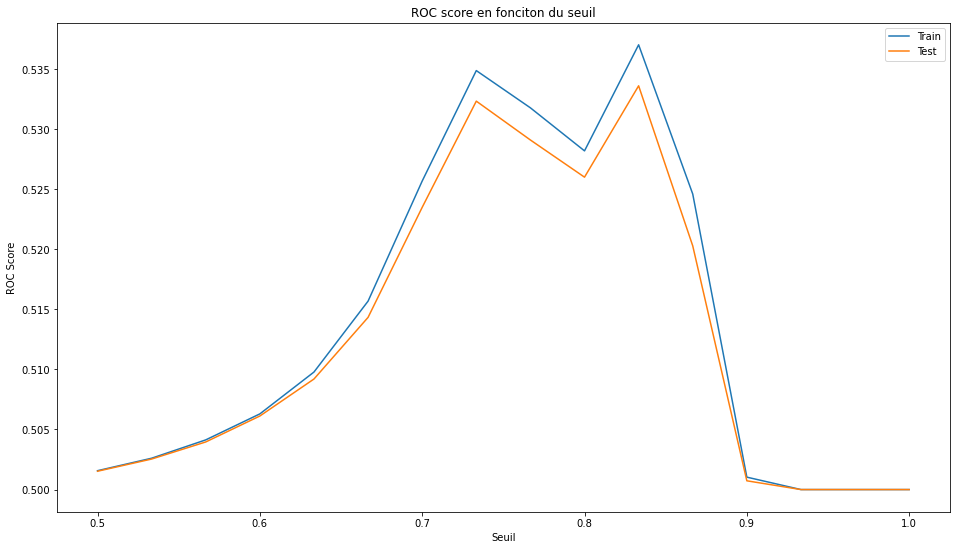

In [102]:
train_score = list()
test_score = list()
seuil = list()

for key in scores.keys():
    train_score.append(np.array(scores[key]['train']).mean())
    test_score.append(np.array(scores[key]['test']).mean())
    seuil.append(key)


plt.figure(figsize=(16,9))
plt.plot(seuil, train_score, label='Train')
plt.plot(seuil, test_score, label='Test')
plt.legend()

plt.title('AUC_ROC score en fonciton du seuil')
plt.xlabel('Seuil')
plt.ylabel('AUC_ROC Score')
plt.show

plt.savefig("AUC_ROC score en fonction du seuil, content based", dpi=300, pad_inches=0.1,bbox_inches='tight')

In [33]:
i = np.array(train_score).argmax()

print(f'Seuil = {seuil[i]}')
print(f'Train_mean_AUC_ROC = {train_score[i]}')
print(f'Train_mean_AUC_ROC = {test_score[i]}')

Seuil = 0.8333333333333333
Train_mean_ROC = 0.5370241901526518
Train_mean_ROC = 0.5336104673311515


## Item based recomendation

In [37]:
def get_reco_from_traklist(user_track_vector_list, n=50):
    
    reco_full = pd.DataFrame({'track_id': [], 'cosine_similarity': []})

    for track_vec in user_track_vector_list:
        try:
            if n>=0:
                reco = get_reco([track_vec],50)
            else:
                reco = get_reco([track_vec],-1)
                
            reco_full = pd.concat([reco_full,reco.iloc[1:]])
        except:
            pass
    if n>=0:
        return reco_full.sort_values(by=['cosine_similarity'], ascending=False).iloc[0:n]
    else:
        return reco_full.groupby(['track_id']).mean().reset_index()

In [63]:
def top_user_music(user_id, n=10):
    a = df_train[df_train['user_id']==user_id]
    l = a['track_id']
    return set(l.value_counts()[:n].index)

### Essais sur un utilissateur

In [76]:
user = 1

In [77]:
user_tracks_train = set([x for x in df_train[df_train['user_id']==user]['track_id'].unique()])
user_track_list = pd.DataFrame({'track_id': list(top_user_music(user,10))})
vector_list = pd.merge(user_track_list, df_track, how='left', left_on=['track_id'], right_on = ['track_id'])['vector'].values

In [78]:
recomended_tracks = set(get_reco_from_traklist(vector_list,50)['track_id'].values)

#### Metrique K_best

In [79]:
k = k_best(user_tracks_train, recomended_tracks)
print(k)

K_best ressults: 
CG = 2
DCG = 0.550873790152367
NDCG = 0.3377667179999921
P@K = 0.04



In [80]:
k = k_best(user_tracks_test, recomended_tracks)
print(k)

K_best ressults: 
CG = 2
DCG = 0.5875854002677814
NDCG = 0.36027633868415837
P@K = 0.04



#### Metrique AUC_ROC

In [85]:
recomended_tracks = get_reco_from_traklist(vector_list,50)
recomended_tracks['true_train'] = recomended_tracks['track_id'].apply(lambda x: 1 if x in user_tracks_train else 0)
recomended_tracks['true_test'] = recomended_tracks['track_id'].apply(lambda x: 1 if x in user_tracks_test else 0)

In [94]:
recomended_tracks['pred'] = recomended_tracks['cosine_similarity'].apply(lambda x : 1 if x>0.5 else 0)

In [95]:
# Calcule des metriques sur train
y_pred = recomended_tracks['pred'].values
y_true = recomended_tracks['true_train'].values

roc_auc_score(y_true, y_pred)

0.5

In [96]:
# Calcule des metriques sur test
y_pred = recomended_tracks['pred'].values
y_true = recomended_tracks['true_test'].values

roc_auc_score(y_true, y_pred)

0.5

### Evaluation du model sur l'ensemble des utilisateurs

### K_best

In [97]:
train_scores = list()
test_scores = list()
user_id = list()

for user in tqdm(df_train['user_id'].unique()):
    user_tracks_train = set([x for x in df_train[df_train['user_id']==user]['track_id'].unique()])
    user_tracks_test = set([x for x in df_test[df_test['user_id']==user]['track_id'].unique()])
    
    
    user_track_list = pd.DataFrame({'track_id': list(top_user_music(user,10))})
    vector_list = pd.merge(user_track_list, df_track, how='left', left_on=['track_id'], right_on = ['track_id'])['vector'].values
    recomended_tracks = set(get_reco_from_traklist(vector_list)['track_id'].values)
    
    k = k_best(user_tracks_train, recomended_tracks)
    train_scores.append(k.NDCG())
    
    if len(user_tracks_test)!=0:
        k = k_best(user_tracks_test, recomended_tracks)
        test_scores.append(k.NDCG())
    else:
        test_scores.append(1)
    
    user_id.append(user)

100%|████████████████████████████████████████████████████████████████████████████████| 959/959 [07:22<00:00,  2.17it/s]


In [98]:
print('Train_mean_NDCG = ', np.array(train_scores).mean())
print('Test_mean_NDCG = ', np.array(test_scores).mean())

train =  0.22765694395054947
test =  0.12947280169865108


### AUC_ROC

In [99]:
train_scores = list()
test_scores = list()
user_id = list()

s=0.83

for user in tqdm(df_train['user_id'].unique()):
    user_tracks_train = set([x for x in df_train[df_train['user_id']==user]['track_id'].unique()])
    user_tracks_test = set([x for x in df_test[df_test['user_id']==user]['track_id'].unique()])
    
    user_track_list = pd.DataFrame({'track_id': list(top_user_music(user,10))})
    vector_list = pd.merge(user_track_list, df_track, how='left', left_on=['track_id'], right_on = ['track_id'])['vector'].values
    recomended_tracks = get_reco_from_traklist(vector_list,-1)
    
    recomended_tracks['pred'] = recomended_tracks['cosine_similarity'].apply(lambda x : 1 if x>s else 0)
    recomended_tracks['true_train'] = recomended_tracks['track_id'].apply(lambda x: 1 if x in user_tracks_train else 0)
    recomended_tracks['true_test'] = recomended_tracks['track_id'].apply(lambda x: 1 if x in user_tracks_test else 0)
    
    try:
        y_pred = recomended_tracks['pred'].values

        y_true_train = recomended_tracks['true_train'].values
        score = roc_auc_score(y_true_train, y_pred)  


        y_true_test = recomended_tracks['true_test'].values
        score = roc_auc_score(y_true_test, y_pred)

        train_scores.append(score)
        test_scores.append(score)
        user_id.append(user)
    except:
        pass

100%|████████████████████████████████████████████████████████████████████████████████| 959/959 [08:34<00:00,  1.86it/s]


In [101]:
print(f'Train_mean_AUC_ROC =: {np.array(train_scores).mean()}')
print(f'Test_mean_AUC_ROC =: {np.array(test_scores).mean()}')

Train_mean_ROC =: 0.5000733419243163
Test_mean_ROC =: 0.5000733419243163
